In [3]:
%pip install openpyxl

In [58]:
import numpy as np

import pandas as pd

import os

df = pd.read_excel(os.path.abspath('milano_housing_02_2_23.xlsx')) # kaggle dataset showcasing information about apartments in Milan

df.head(2)

,index,rooms,m2,bathrooms,floor,condominium_expenses,date,contract,typology,total_floors,...,energy_certification,co2_emissions,elevator,floor_level,heating_centralized,heating_radiator,heating_gas,air_conditiong_centralized,air_conditioning_heat,renewable_energy_performance_index_KWh/m2
0,0,3,140.0,2,4,535,08/02/2023,sale,apartment | entire property | stately property...,6 floors,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,NaN
1,0,4,121.0,2,3,200,17/02/2023,sale,apartment | entire property | stately property...,7 floors,...,NaN,NaN,1,3,autonomous,to radiators,gas powered,system preparation,NaN,NaN


In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# keeping only m2 as feature and price as label
df = df[['m2', 'price']]

# remove abnormaly large apartments
df = df[df['m2'] <= 200]

# drop rows with missing values
df = df.dropna()

# scaling my variables
df['m2'] = scaler.fit_transform(df[['m2']])
df['price'] = scaler.fit_transform(df[['price']])

# adding a dummy variable for my model
df['ones'] = 1

df.describe()

,m2,price,ones
count,1.811000e+03,1811.000000,1811.0
mean,4.315831e-17,0.000000,1.0
std,1.000276e+00,1.000276,0.0
min,-2.488341e+00,-1.442513,1.0
25%,-7.530941e-01,-0.696940,1.0
50%,-1.243816e-01,-0.279925,1.0
75%,6.300734e-01,0.402464,1.0
max,2.516211e+00,6.089038,1.0


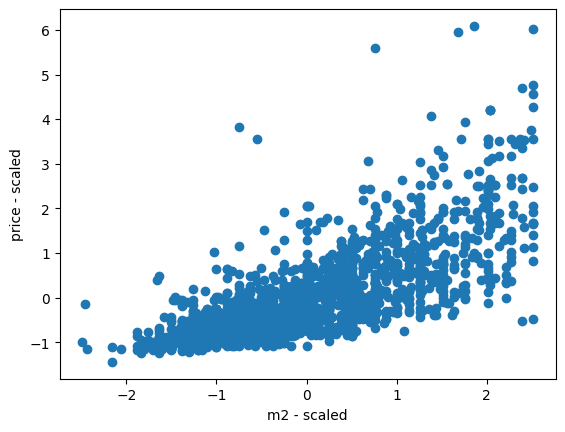

In [62]:
from matplotlib import pyplot as plt

plt.scatter(x=df.m2, y=df.price)
plt.xlabel('m2 - scaled')
plt.ylabel('price - scaled')
plt.show()

In [63]:
# We want to model the price of houses in Milan using the m2 feature only

# let's attempt to do so by using a linear regression model

# y = w0 + w1x1

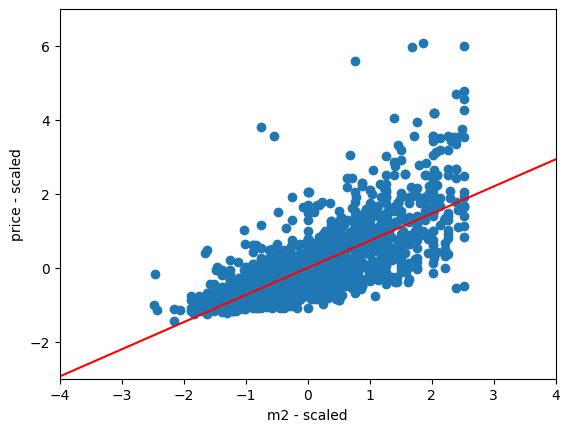

In [69]:
# APPROACH #1 - use the normal equation solution to find the best (w0, w1) which will determine the best fitting line

# W = (X^T X)^-1 X^T y

# lets define X, X^T and y so that we can calculate W

X = df[['ones', 'm2']].to_numpy().reshape(df.shape[0],df.shape[1]-1)
XT = X.transpose()
Y = df['price'].to_numpy().reshape(df.shape[0], 1)
W = np.linalg.inv(XT @ X) @ (XT @ Y)


# lets plot it and try it out

from matplotlib import pyplot as plt

xs = np.linspace(-4, 4, 100)
ys = W[0] + W[1]*xs
plt.plot(xs, ys, color='red')

plt.scatter(x=df.m2, y=df.price)
plt.xlabel('m2 - scaled')
plt.ylabel('price - scaled')
plt.ylim(-3, 7)   # x-axis range from 0 to 10
plt.xlim(-4, 4) 
plt.show()

In [70]:
# APPROACH #2 - use machine learning to "learn" the best fitting line to the data

# let's define our loss function: L = 1/2*∑[(w0 + w1x1) - y]^2

# below is the derivative of the loss function with respect to W

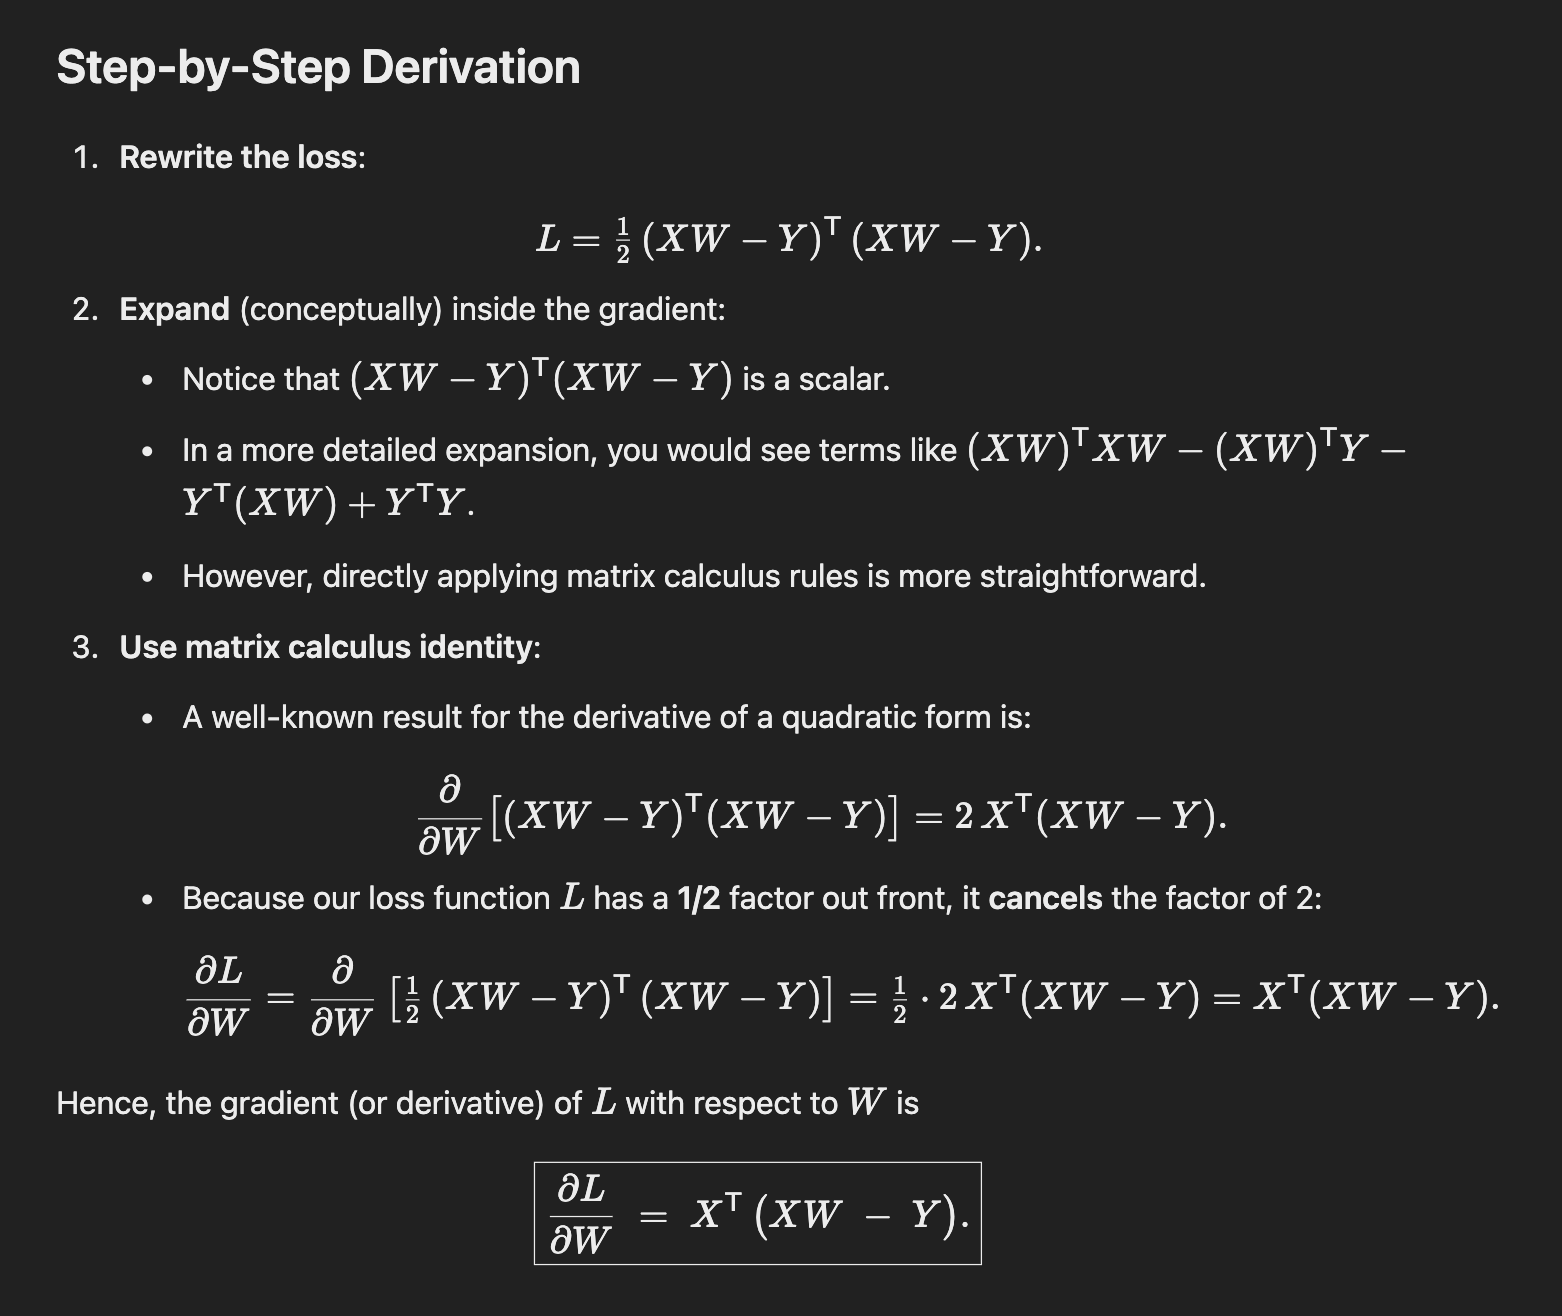

In [72]:
# X has (1811, 2) shape
# W has (2, 1) shape
# XW has (1811, 1) shape
# XW - Y has (1811, 1) shape
# X.T has (2, 1811) shape
# gradient has (2, 1) shape -- 2 vectors

# we will use GRADIENT DESCENT algorithm to updated iteratively the weights of our model converging towards the optimal solution
# point of attention: we will use BATCH GRADIENT DESCENT for now

# update rule: W -= ∂ (X.T @ (X@W - Y))   where ∂ is the learning rate hyper-parameter which will be arbitrarily set to 0.01

# heuristic: W will be randomly initialized as a zero vector to start off

# tip: we will scale our features to avoid huge gradient values (already done)

# we will be using different W to distinguish from W obtained by analytical approach which I would like to maintain

In [77]:
from tqdm import tqdm

class LR:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.W = np.zeros(2).reshape(2, 1)

    def train(self, epochs, alpha):
        losses = []
        weights = []
        for epoch in tqdm(range(epochs)):
            # update weights and store updated weight
            gradient = (self.X.T @ ((self.X @ self.W) - self.Y))
            # print(f'gradient value is {gradient}')
            self.W = self.W - alpha * gradient
            #print(f'new weights are {self.W}')
            weights.append(self.W)

            # calculate loss with updated weight and store it
            loss = 1/2 * (((self.X @ self.W) - self.Y).T @ ((self.X @ self.W) - self.Y))
            #print(f'loss value is {loss[0][0]}')
            losses.append(loss[0][0])
        return losses, weights

In [78]:
lin_regression = LR(X, Y)

losses, weights = lin_regression.train(50, 0.001)

100%|██████████| 50/50 [00:00<00:00, 25001.81it/s]


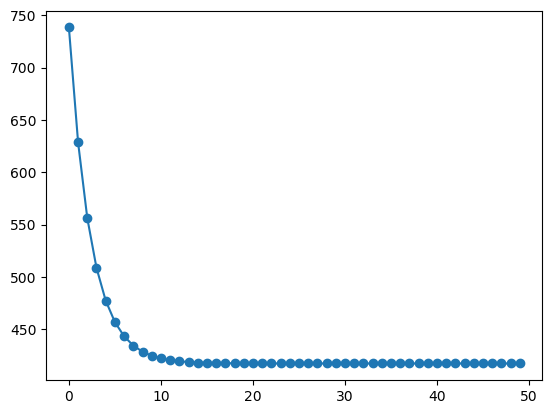

In [79]:
plt.plot(losses, marker='o')

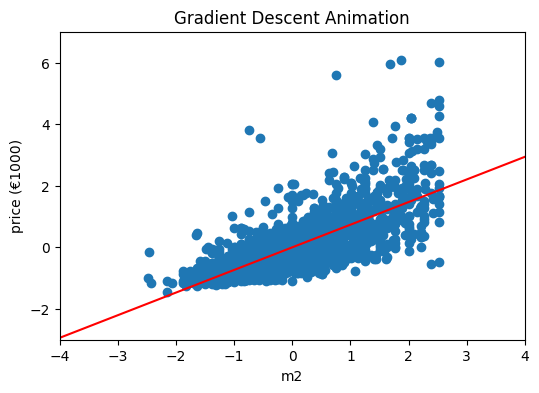

In [91]:
from matplotlib.animation import FuncAnimation

slopes = []
intercepts = []
for w in weights:
    intercept = w[0][0]
    intercepts.append(intercept)
    slope = w[1][0]
    slopes.append(slope)


# ANIMATION FUNCTIONs
def init():
    line.set_data([], [])
    return (line,)

def update(frame):
    # This function updates the line for each frame in the animation.
    # 'frame' is an integer index from 0 to iterations-1.
    
    # 1. Get the slope/intercept for the current iteration
    slope_i = slopes[frame]
    intercept_i = intercepts[frame]

    # 2. Generate x-values for plotting the line
    x_line = np.linspace(-4, 4, 100)
    # 3. Predict y-values with the current slope/intercept
    y_line = slope_i * x_line + intercept_i

    # 4. Update the line data
    line.set_data(x_line, y_line)

    ax.set_title(f"Gradient Descent Animation - iteration nr {frame}")

    return (line,)


fig, ax = plt.subplots(figsize=(6,4))
line, = ax.plot([], [], color='black', label='Model')

# CREATE & RUN THE ANIMATION
anim = FuncAnimation(
    fig,        # figure object
    update,     # function to update each frame
    frames=len(weights), 
    init_func=init,  # initialization function
    interval=400,    # time in ms between frames
    blit=True
)

# keeping initialy line obtained via analytical solution
xs = np.linspace(-4, 4, 100)
ys = W[0] + W[1]*xs
red_line, = ax.plot(xs, ys, color='red', label='Reference Line (constant)')


ax.scatter(x=scaler.fit_transform(df[['m2']]), y=scaler.fit_transform(df[['price']])) # SCALED VALUES
ax.set_xlabel('m2')
ax.set_ylabel('price (€1000)')
ax.set_ylim(-3, 7)   # x-axis range from 0 to 10
ax.set_xlim(-4, 4)
ax.set_title("Gradient Descent Animation")

plt.show()

anim.save("my_animation.gif", writer="pillow")

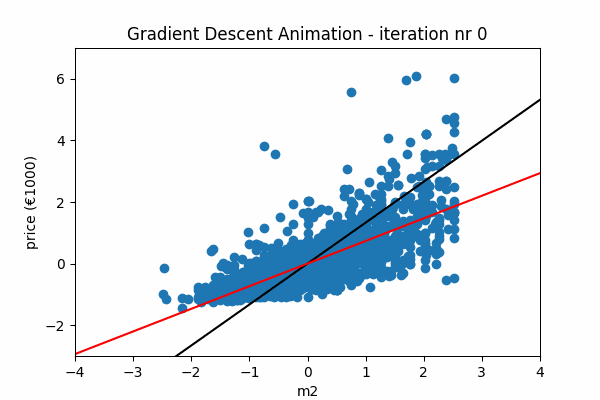

In [92]:
from IPython.display import Image
Image("my_animation.gif")

In [93]:
# OK now let's do something extremely similar with stochastic gradient descent
# that is using only 1 example per time to update the weights
# in practice this results in faster training time but a more erratic convergence towards the optimal weights

In [168]:
from tqdm import tqdm

class LR_sgd:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.W = np.zeros(2).reshape(2, 1)

    def train(self, epochs, alpha):
        losses = []
        weights = []
        
        for epoch in tqdm(range(epochs)):
            # picks random example from X
            row_idx = np.random.choice(X.shape[0])
            random_example = X[row_idx].reshape(1, 2)
            y = Y[row_idx]
            
            # update weights and store updated weight based solely on the random example
            gradient = (random_example.T @ ((random_example @ self.W) - y))
            # print(f'gradient value is {gradient}')
            self.W = self.W - alpha * gradient
            # print(f'new weights are {self.W}')
            weights.append(self.W)

            # calculate loss with updated weight and store it
            loss = 1/2 * (((self.X @ self.W) - self.Y).T @ ((self.X @ self.W) - self.Y))
            #print(f'loss value is {loss[0][0]}')
            losses.append(loss[0][0])
        return losses, weights

In [169]:
lin_regression2 = LR_sgd(X, Y)

losses2, weights2 = lin_regression2.train(400, 0.01)

100%|██████████| 400/400 [00:00<00:00, 19047.70it/s]


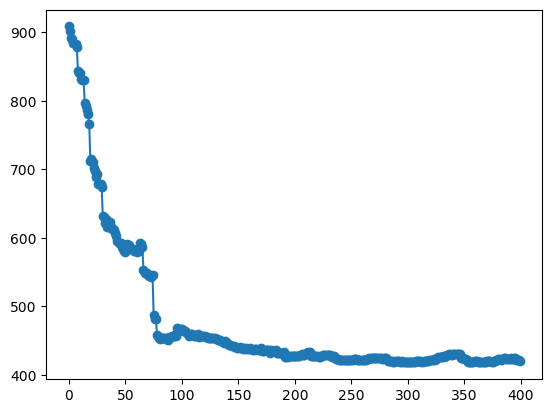

In [170]:
plt.plot(losses2, marker='o')

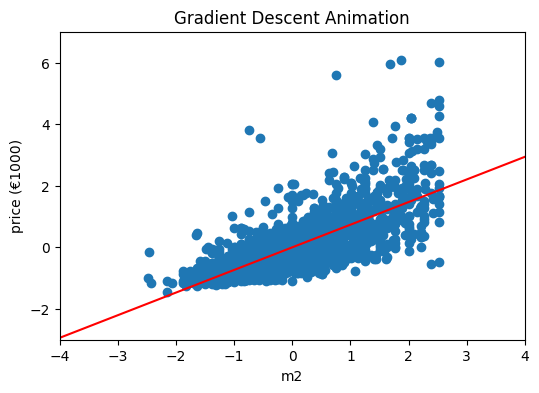

In [171]:
from matplotlib.animation import FuncAnimation

slopes = []
intercepts = []
for w in weights2:
    intercept = w[0][0]
    intercepts.append(intercept)
    slope = w[1][0]
    slopes.append(slope)


# ANIMATION FUNCTIONs
def init():
    line.set_data([], [])
    return (line,)

def update(frame):
    # This function updates the line for each frame in the animation.
    # 'frame' is an integer index from 0 to iterations-1.
    
    # 1. Get the slope/intercept for the current iteration
    slope_i = slopes[frame]
    intercept_i = intercepts[frame]

    # 2. Generate x-values for plotting the line
    x_line = np.linspace(-4, 4, 100)
    # 3. Predict y-values with the current slope/intercept
    y_line = slope_i * x_line + intercept_i

    # 4. Update the line data
    line.set_data(x_line, y_line)

    ax.set_title(f"Gradient Descent Animation - iteration nr {frame}")

    return (line,)


fig, ax = plt.subplots(figsize=(6,4))
line, = ax.plot([], [], color='black', label='Model')

# CREATE & RUN THE ANIMATION
anim = FuncAnimation(
    fig,        # figure object
    update,     # function to update each frame
    frames=len(weights2), 
    init_func=init,  # initialization function
    interval=100,    # time in ms between frames
    blit=True
)

# keeping initialy line obtained via analytical solution
xs = np.linspace(-4, 4, 100)
ys = W[0] + W[1]*xs
red_line, = ax.plot(xs, ys, color='red', label='Reference Line (constant)')


ax.scatter(x=scaler.fit_transform(df[['m2']]), y=scaler.fit_transform(df[['price']])) # SCALED VALUES
ax.set_xlabel('m2')
ax.set_ylabel('price (€1000)')
ax.set_ylim(-3, 7)   # x-axis range from 0 to 10
ax.set_xlim(-4, 4)
ax.set_title("Gradient Descent Animation")

plt.show()

anim.save("my_animation.gif", writer="pillow")

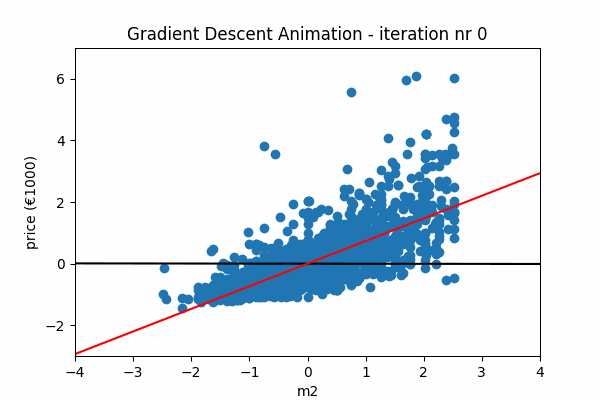

In [172]:
from IPython.display import Image
Image("my_animation.gif")

In [173]:
# Final thoughts: in practice what is usually done is neither batch nor stochastic gradient descent. Instead mini-batch where you simply calculate
# the gradient using a subset of the training examples

In [94]:
# importance of scaling features and lr size to avoid explosion of losses - why?
# effect of scaling on model interpretability